In [1]:
#!PYTHONPATH=$PWD python3 benchmarks/benchmark_flash_attention.py > bench.log

In [2]:
#!PYTHONPATH=$PWD python3 benchmarks/benchmark_causal.py > bench_causal.log

In [7]:
!echo "PYTHONPATH=$PWD python3 benchmarks/benchmark_flash_attention.py"  | docker-compose run flashattention > bench_flash_attention.log

Creating flash-attention_flashattention_run ... 
ting flash-attention_flashattention_run ... done

In [6]:
!echo "PYTHONPATH=$PWD python3 benchmarks/benchmark_causal.py"  | docker-compose run flashattention > bench_causal.log

Creating flash-attention_flashattention_run ... 
ting flash-attention_flashattention_run ... done

In [8]:
!cat bench_causal.log


== PyTorch ==

NVIDIA Release 22.12 (build 49968248)
PyTorch Version 1.14.0a0+410ce96

Container image Copyright (c) 2022, NVIDIA CORPORATION & AFFILIATES. All rights reserved.

Copyright (c) 2014-2022 Facebook Inc.
Copyright (c) 2011-2014 Idiap Research Institute (Ronan Collobert)
Copyright (c) 2012-2014 Deepmind Technologies    (Koray Kavukcuoglu)
Copyright (c) 2011-2012 NEC Laboratories America (Koray Kavukcuoglu)
Copyright (c) 2011-2013 NYU                      (Clement Farabet)
Copyright (c) 2006-2010 NEC Laboratories America (Ronan Collobert, Leon Bottou, Iain Melvin, Jason Weston)
Copyright (c) 2006      Idiap Research Institute (Samy Bengio)
Copyright (c) 2001-2004 Idiap Research Institute (Ronan Collobert, Samy Bengio, Johnny Mariethoz)
Copyright (c) 2015      Google Inc.
Copyright (c) 2015      Yangqing Jia
Copyright (c) 2013-2016 The Caffe contributors
All rights reserved.

Various files include modifications (c) NVIDIA CORPORATION & AFFILIATES.  All rights reserved.

This 

In [8]:
noncausal_data={}
with open("bench_flash_attention.log","r") as fp:
    att_type=""
    pass_dir=""
    bypass=0
    time_str=""
    for ln in fp:
        if bypass >1:
            #print("<pass",bypass,">")            
            bypass-=1 #Ignore lines until bypass==1
        elif bypass == 1:
            #Collect runtime measurement
            time_str=ln.split()[0]
            noncausal_data[att_type+pass_dir]=float(time_str)
            bypass=0
            #print(float(time_str))
        else:
            if "FlashAttention" in ln:
                # Identify attention type and direction for experiment
                att_type="FlashAttention"
                pass_dir=ln.split("-")[1][1:].strip()
                bypass=3
                #print(att_type)
                #print(pass_dir)
            if "PyTorch Standard Attention" in ln:
                # Identify attention type and direction for experiment
                att_type="StandardAttention"
                pass_dir=ln.split("-")[1][1:].strip()
                bypass=3
                #print(att_type)
                #print(pass_dir)   
                
causal_data={}
with open("bench_causal.log","r") as fp:
    att_type=""
    pass_dir=""
    bypass=0
    time_str=""
    for ln in fp:
        if bypass >1:
            #print("<pass",bypass,">")            
            bypass-=1 #Ignore lines until bypass==1
        elif bypass == 1:
            #Collect runtime measurement
            time_str=ln.split()[0]
            causal_data[att_type+pass_dir]=float(time_str)
            bypass=0
            #print(float(time_str))
        else:
            if "FlashAttention Triton OG" in ln:
                # Identify attention type and direction for experiment
                att_type="FlashAttention Triton OG"
                pass_dir=ln.split("-")[1][1:].strip()
                bypass=3
                #print(att_type)
                #print(pass_dir)
            elif "FlashAttention" in ln:
                # Identify attention type and direction for experiment
                att_type="FlashAttention"
                pass_dir=ln.split("-")[1][1:].strip()
                bypass=3
                #print(att_type)
                #print(pass_dir)
            if "PyTorch Attention" in ln:
                # Identify attention type and direction for experiment
                att_type="StandardAttention"
                pass_dir=ln.split("-")[1][1:].strip()
                bypass=3
                #print(att_type)
                #print(pass_dir)                   

In [9]:
causal_data

{'FlashAttentionForward pass': 1.06,
 'FlashAttentionBackward pass': 2.62,
 'FlashAttentionForward + Backward pass': 3.7,
 'StandardAttentionForward pass': 8.78,
 'StandardAttentionBackward pass': 11.51,
 'StandardAttentionForward + Backward pass': 20.24,
 'FlashAttention Triton OGForward pass': 1.03,
 'FlashAttention Triton OGBackward pass': 7.48,
 'FlashAttention Triton OGForward + Backward pass': 8.51}

## Perf benchmark result

In [29]:
#data

4.747053045186641
5.4702702702702695
2.378378378378378


Text(0.5, 1.0, 'NVIDIA RTX 3090 FlashAttention speedup, headdim 64')

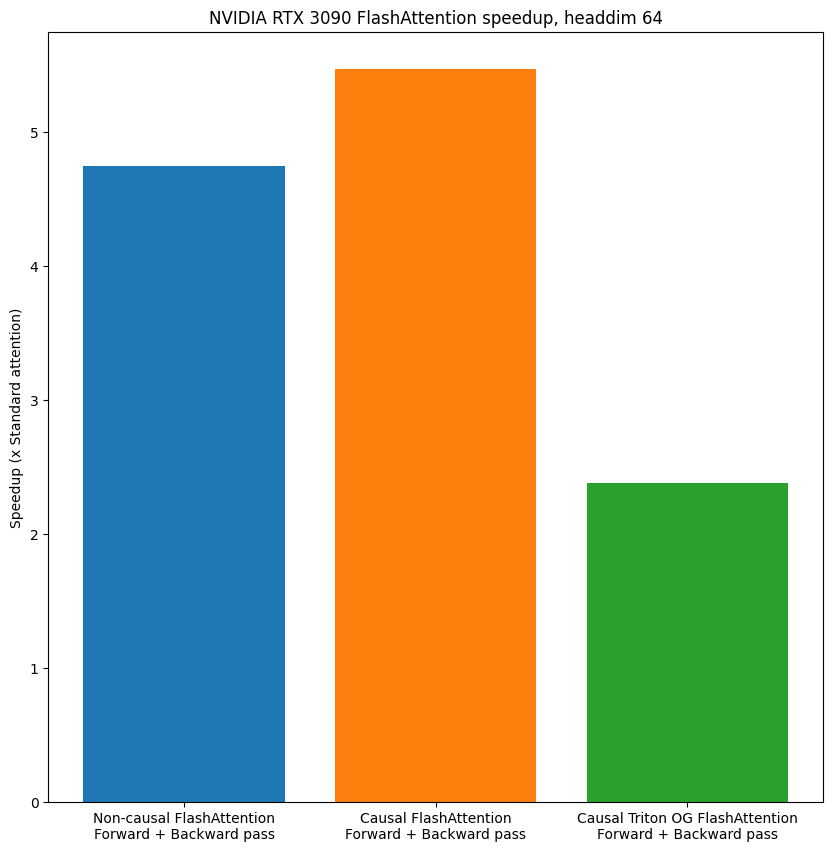

In [18]:
import matplotlib.pyplot as plt

xlabels=["Non-causal FlashAttention\nForward + Backward pass","Causal FlashAttention\nForward + Backward pass","Causal Triton OG FlashAttention\nForward + Backward pass"]

noncausal_baseline=noncausal_data["StandardAttentionForward + Backward pass"]
noncausal_yheights=[noncausal_baseline/noncausal_data["FlashAttentionForward + Backward pass"]]
print(noncausal_baseline/noncausal_data["FlashAttentionForward + Backward pass"])

causal_baseline=causal_data["StandardAttentionForward + Backward pass"]
causal_yheights=[causal_baseline/causal_data["FlashAttentionForward + Backward pass"]]
print(causal_baseline/causal_data["FlashAttentionForward + Backward pass"])

causal_tritonOG_baseline=causal_data["StandardAttentionForward + Backward pass"]
causal_tritonOG_yheights=[causal_tritonOG_baseline/causal_data["FlashAttention Triton OGForward + Backward pass"]]
print(causal_tritonOG_baseline/causal_data["FlashAttention Triton OGForward + Backward pass"])

plt.figure(figsize=(10,10))
plt.bar(xlabels[0],noncausal_yheights)
plt.bar(xlabels[1],causal_yheights)
plt.bar(xlabels[2],causal_tritonOG_yheights)
plt.ylabel("Speedup (x Standard attention)")
plt.title("NVIDIA RTX 3090 FlashAttention speedup, headdim 64")

Text(0.5, 1.0, 'NVIDIA RTX 3090 FlashAttention execution time, headdim 64')

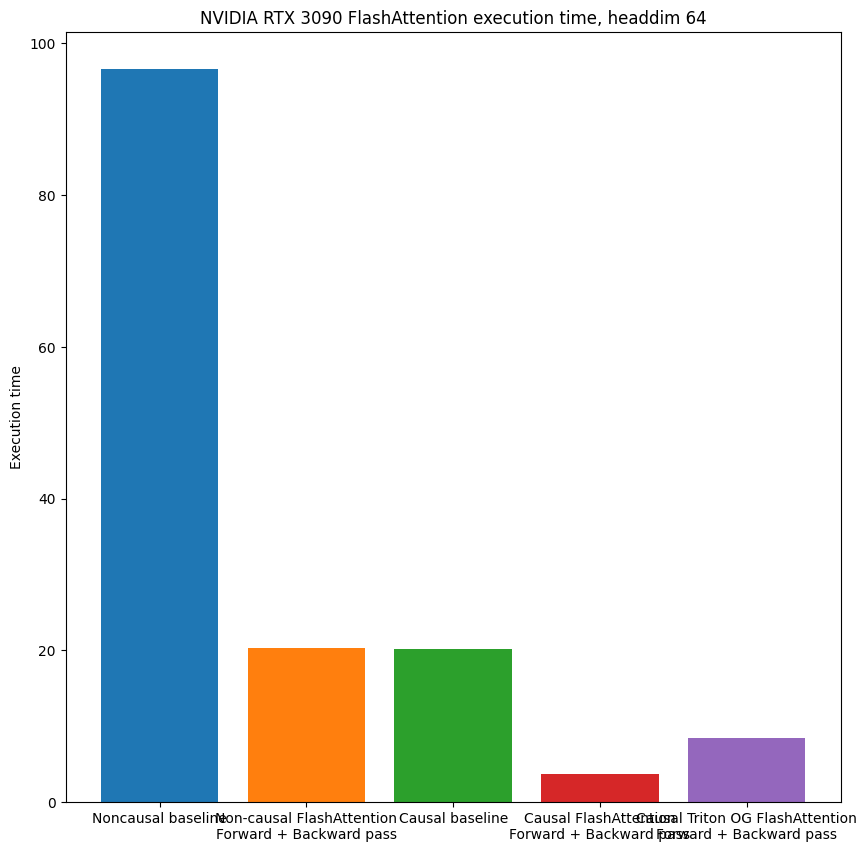

In [22]:
plt.figure(figsize=(10,10))
plt.bar("Noncausal baseline",noncausal_baseline)
plt.bar(xlabels[0],noncausal_data["FlashAttentionForward + Backward pass"])
plt.bar("Causal baseline",causal_baseline)
plt.bar(xlabels[1],causal_data["FlashAttentionForward + Backward pass"])
plt.bar(xlabels[2],causal_data["FlashAttention Triton OGForward + Backward pass"])
plt.ylabel("Execution time")
plt.title("NVIDIA RTX 3090 FlashAttention execution time, headdim 64")